## DBSCAN
#### Gavin Daves, Rice University
#### INDE 577, Dr. Randy Davila

In this notebook, we will utilize DBSCAN in Python and use the model(s) we create on the Spotify dataset.

In [176]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys

import warnings
warnings.filterwarnings('ignore')


sns.set_theme()

In [177]:
# Loading the data

# Add the top-level directory to the system path
sys.path.append('../../')

# Load the data
import clean_data as sd

df = sd.get_df()

# Get a sample of the data

investigation_df = df.sample(1000, random_state=2024)

### Background

Similar to the $K$-Means Clustering Notebook, let's take a sample of our song data and build a DBSCAN model based on audio metrics and maximizing silhouette score.

In [178]:
# Prepare the data

X = investigation_df[['danceability', 'energy', 'loudness', 
          'speechiness', 'acousticness', 'instrumentalness', 
          'liveness', 'valence', 'tempo', 'explicit']]

In [179]:
# Perform PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
scaler = StandardScaler()

X_pca = pca.fit_transform(X)
X_pca = scaler.fit_transform(X_pca)

In [180]:
# Finding the best epsilon, min_samples pairing for our dataset based on Silhouette Score

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

best_score = -1
best_eps = 0
best_min_samples = 0

for eps in np.arange(0.1, 10, 0.1):
    for min_samples in range(2, 10):
        # Fit the DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_pca)
        
        labels = dbscan.labels_
        
        # Skip if only one cluster is found
        if len(set(labels)) == 1 or (len(set(labels)) == 2 and {-1}.issubset(set(labels))):
            continue
        score = silhouette_score(X_pca, labels)
        
        # Update the best score
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples
            
print(f'Best Silhouette Score: {best_score}')
print(f'Best Epsilon: {best_eps}')
print(f'Best Min Samples: {best_min_samples}')

Best Silhouette Score: 0.6123616631052108
Best Epsilon: 0.6
Best Min Samples: 6


After looking at reasonable pairs of epsilon and min_sample values, we find that the highest silouette score is at epsilon = .6 and min_samples = 6. Now, we can build our DBSCAN model and visualize the clusters:

In [181]:
# Build a DBSCAN model

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(X_pca)

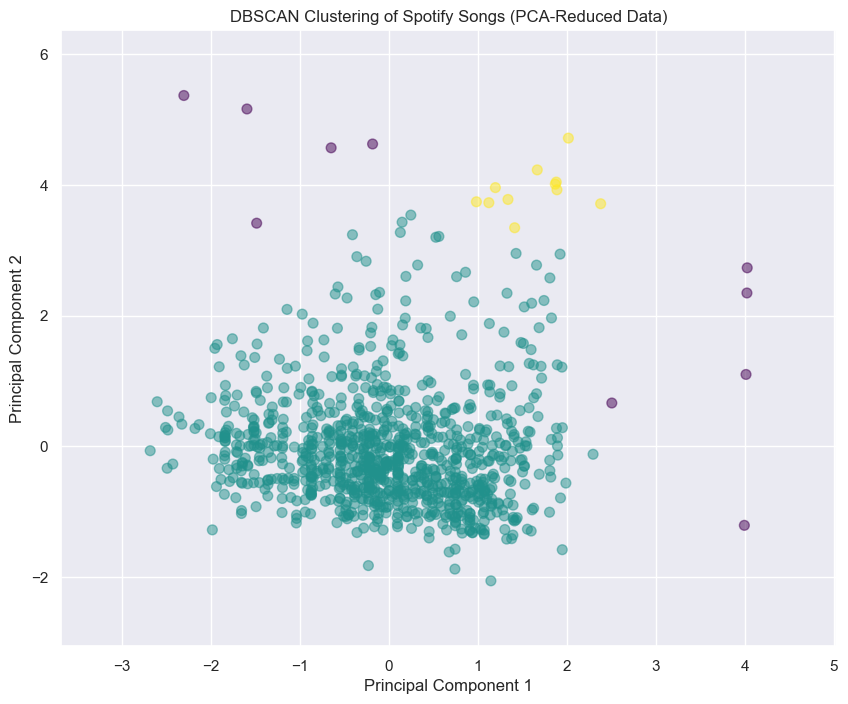

Number of clusters: 2


In [182]:
# Visualize the clusters

# Determine the boundaries for plotting
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

plt.figure(figsize=(10, 8))

# Scatter plot for all points, coloring them according to the cluster assignment
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.5)


plt.title("DBSCAN Clustering of Spotify Songs (PCA-Reduced Data)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Counting the number of unique clusters (ignoring noise as a cluster if present)
unique_clusters = set(clusters) - {-1}  # -1 is usually used for noise in DBSCAN
n_clusters = len(unique_clusters)
print(f"Number of clusters: {n_clusters}")


In [183]:
# Counting the number of points in each cluster

for cluster in unique_clusters:
    n_points = np.sum(clusters == cluster)
    print(f"Cluster {cluster} contains {n_points} points")


# Counting the number of noise points

n_noise = np.sum(clusters == -1)
print(f"Number of noise points: {n_noise}")

Cluster 0 contains 979 points
Cluster 1 contains 11 points
Number of noise points: 10


### Model Analysis

As we can see, most of the data points were thrown into one cluster, with another small cluster formation right above it. With a high silhouette score, we know that the clusters are quite well-defined. Further, there are some points left out of the model and considered noise, indicating that the model hasn't completely overfit the data either.

Overall, given the good high silhouette score, this DBSCAN model can be considered adequate.